In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

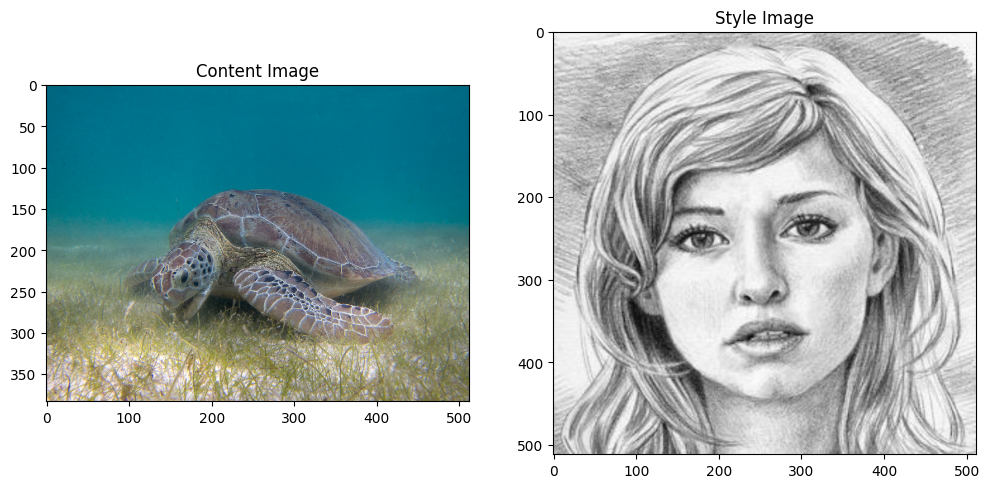

In [7]:
content_path = "/content/drive/MyDrive/CIS581/EvaluationImages/Content/Green_Sea_Turtle_grazing_seagrass.jpg"
# photo0 photo1 photo4 photo7 photo10 1_content 2_content Green_Sea_Turtle_grazing_seagrass
style_path = "/content/drive/MyDrive/CIS581/EvaluationImages/Style/1_style.jpg"
# VanGogh ukiyoe cezanne monet 1_style 2_style modern andre

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [8]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [10]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [11]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [12]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [13]:

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [14]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

In [15]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [16]:
image = tf.Variable(content_image)

In [17]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

In [19]:
style_weight=1e-2
content_weight=1e3

In [20]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    # loss = style_weight * style_loss + content_weight * content_loss
    loss = style_loss + content_loss
    return loss, style_loss, content_loss

In [21]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss, style_loss, content_loss = style_content_loss(outputs)


  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  return loss, style_loss, content_loss

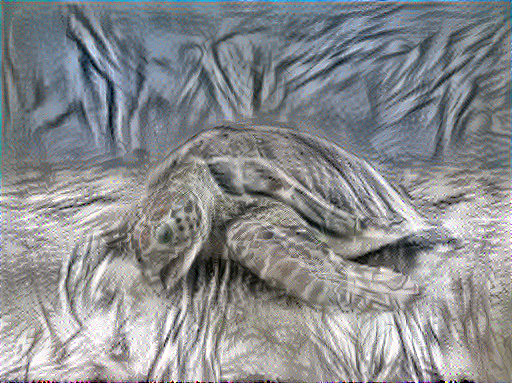

Train step: 1000
249304.81423611112
379976.0672348485
Total time: 80.3
['block5_conv2']
['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
100000.0


In [22]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
style_losses_epoch = []
content_losses_epoch = []
for n in range(epochs):
  style_losses = 0
  content_losses = 0
  for m in range(steps_per_epoch):
    step += 1
    loss, style_loss, content_loss = train_step(image)
    style_losses += style_loss.numpy()
    content_losses += content_loss.numpy()
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  print(style_losses / m)
  print(content_losses / m)
  style_losses_epoch.append(style_losses / m)
  content_losses_epoch.append(content_losses / m)

end = time.time()
print("Total time: {:.1f}".format(end-start))
print(content_layers)
print(style_layers)
print(content_weight / style_weight)

In [23]:
content_name = content_path.split('/')[-1][:-4]
style_name = style_path.split('/')[-1][:-4]
file_name = f'vgg19-{content_name}-{style_name}.jpg'
tensor_to_image(image).save(file_name)

# try:
#   from google.colab import files
# except ImportError:
#    pass
# else:
#   files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

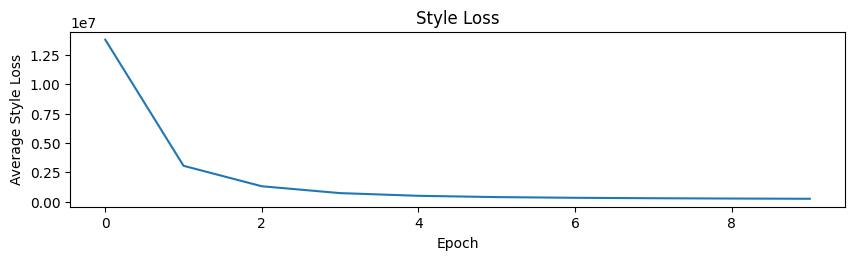

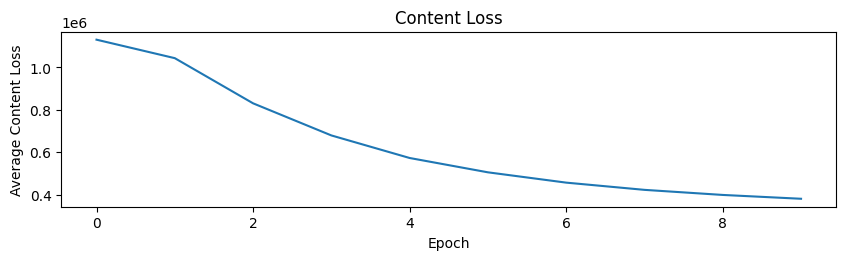

In [24]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(style_losses_epoch)
plt.title("Style Loss")
plt.ylabel("Average Style Loss")
plt.xlabel("Epoch")

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 2)
plt.plot(content_losses_epoch)
plt.title("Content Loss")
plt.ylabel("Average Content Loss")
plt.xlabel("Epoch")
plt.show()